In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, date_format, count, avg, round

spark = SparkSession.builder \
    .appName("Integrated_Analysis_Air_Weather_ZTM") \
    .enableHiveSupport() \
    .getOrCreate()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Sesja Spark utworzona. Gotowy do pracy!")

26/01/14 14:10:16 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
26/01/14 14:10:16 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/14 14:10:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/14 14:10:21 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Sesja Spark utworzona. Gotowy do pracy!


In [2]:
df_air = spark.sql("SELECT * FROM default.air_quality")
df_weather = spark.sql("SELECT * FROM default.weather_data")
df_ztm = spark.sql("SELECT * FROM default.ztm_buses")


print("\n" + "="*50)
print("1. DANE O JAKOŚCI POWIETRZA (OpenAQ)")
print("="*50)
df_air.printSchema()
print("Próbka danych (10 wierszy):")
df_air.show(10, truncate=False)

print("\n" + "="*50)
print("2. DANE POGODOWE (Weather)")
print("="*50)
df_weather.printSchema()
print("Próbka danych (10 wierszy):")
df_weather.show(10, truncate=False)

print("\n" + "="*50)
print("3. DANE KOMUNIKACYJNE (ZTM Autobusy)")
print("="*50)
df_ztm.printSchema()
print("Próbka danych (10 wierszy):")
df_ztm.show(10, truncate=False)


1. DANE O JAKOŚCI POWIETRZA (OpenAQ)
root
 |-- location_id: long (nullable = true)
 |-- location_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- parameter: string (nullable = true)
 |-- datetimelocal: string (nullable = true)
 |-- value: double (nullable = true)
 |-- date: string (nullable = true)

Próbka danych (10 wierszy):


26/01/14 14:10:52 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


+-----------+-------------+-----------+-----------+---------+-------------------+-----+----------+
|location_id|location_name|latitude   |longitude  |parameter|datetimelocal      |value|date      |
+-----------+-------------+-----------+-----------+---------+-------------------+-----+----------+
|28         |Ursynów      |52.16077306|21.03916667|no2      |30-01-2016 00:00:00|17.1 |2026-01-13|
|28         |Ursynów      |52.16077306|21.03916667|no2      |31-01-2016 00:00:00|10.7 |2026-01-13|
|28         |Ursynów      |52.16077306|21.03916667|no2      |01-02-2016 00:00:00|19.4 |2026-01-13|
|28         |Ursynów      |52.16077306|21.03916667|no2      |02-02-2016 00:00:00|16.5 |2026-01-13|
|28         |Ursynów      |52.16077306|21.03916667|no2      |03-02-2016 00:00:00|11.3 |2026-01-13|
|28         |Ursynów      |52.16077306|21.03916667|no2      |04-02-2016 00:00:00|17.7 |2026-01-13|
|28         |Ursynów      |52.16077306|21.03916667|no2      |05-02-2016 00:00:00|21.0 |2026-01-13|
|28       

26/01/14 14:10:59 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


+---------------+----------+-------------+----+----+-----------------+
|lines          |lon       |vehiclenumber|time|lat |brigade          |
+---------------+----------+-------------+----+----+-----------------+
|rowkey         |null      |hour         |line|null|measurement_count|
|20260110_19_111|2.026011E7|19           |111 |4.14|7                |
|20260110_19_115|2.026011E7|19           |115 |8.38|12               |
|20260110_19_119|2.026011E7|19           |119 |3.79|4                |
|20260110_19_123|2.026011E7|19           |123 |4.42|5                |
|20260110_19_125|2.026011E7|19           |125 |4.49|62               |
|20260110_19_143|2.026011E7|19           |143 |2.37|24               |
|20260110_19_145|2.026011E7|19           |145 |1.77|5                |
|20260110_19_146|2.026011E7|19           |146 |0.86|3                |
|20260110_19_147|2.026011E7|19           |147 |4.95|12               |
+---------------+----------+-------------+----+----+-----------------+
only s

In [3]:
from pyspark.sql.functions import col, to_timestamp, from_unixtime, substring, split, regexp_replace, trim
from pyspark.sql.types import DoubleType, IntegerType

print("Biblioteki załadowane.")

Biblioteki załadowane.


In [4]:
from pyspark.sql.functions import col, to_timestamp, from_unixtime
from pyspark.sql.types import DoubleType, IntegerType


df_weather_clean = df_weather \
    .dropDuplicates(["event_time", "weather_id"]) \
    .withColumn("timestamp", from_unixtime(col("event_time")).cast("timestamp")) \
    .select("timestamp", "temp", "pressure", "humidity", "wind_speed", "rain_1h")


df_air_clean = df_air \
    .withColumn("timestamp", to_timestamp(col("datetimelocal"), "dd-MM-yyyy HH:mm:ss")) \
    .withColumn("value", col("value").cast(DoubleType())) \
    .select("timestamp", "location_name", "parameter", "value")


df_ztm_clean = df_ztm \
    .filter(col("lines") != "rowkey") \
    .select(
        col("lines").alias("id_zlozone"),
        col("vehicleNumber").cast(IntegerType()).alias("hour"),
        col("time").alias("line_number"),
        col("lat").cast(DoubleType()).alias("metric_val"), 
        col("brigade").cast(IntegerType()).alias("count")
    )

print("Czyszczenie zakończone.")

print("\n--- POGODA (Próbka) ---")
df_weather_clean.show(3)

print("\n--- SMOG (Próbka - powinny być różne parametry) ---")
df_air_clean.show(5)
print("Dostępne parametry w danych smogowych:")
df_air_clean.select("parameter").distinct().show()

print("\n--- ZTM (Próbka) ---")
df_ztm_clean.show(3)

Czyszczenie zakończone.

--- POGODA (Próbka) ---


+-------------------+-----+--------+--------+----------+-------+
|          timestamp| temp|pressure|humidity|wind_speed|rain_1h|
+-------------------+-----+--------+--------+----------+-------+
|2026-01-13 01:54:17|-8.46|    1017|      90|      2.06|   null|
|2026-01-13 02:05:01|-8.62|    1016|      90|      1.54|   null|
|2026-01-13 02:17:19|-8.31|    1016|      91|      1.54|   null|
+-------------------+-----+--------+--------+----------+-------+


--- SMOG (Próbka - powinny być różne parametry) ---
+-------------------+-------------+---------+-----+
|          timestamp|location_name|parameter|value|
+-------------------+-------------+---------+-----+
|2016-01-30 00:00:00|      Ursynów|      no2| 17.1|
|2016-01-31 00:00:00|      Ursynów|      no2| 10.7|
|2016-02-01 00:00:00|      Ursynów|      no2| 19.4|
|2016-02-02 00:00:00|      Ursynów|      no2| 16.5|
|2016-02-03 00:00:00|      Ursynów|      no2| 11.3|
+-------------------+-------------+---------+-----+
only showing top 5 rows

+----------------+
|       parameter|
+----------------+
|              bc|
|             so2|
|relativehumidity|
|     temperature|
|           um003|
|              co|
|             pm1|
|              o3|
|            pm10|
|             no2|
|            pm25|
+----------------+


--- ZTM (Próbka) ---
+---------------+----+-----------+----------+-----+
|     id_zlozone|hour|line_number|metric_val|count|
+---------------+----+-----------+----------+-----+
|20260110_19_111|  19|        111|      4.14|    7|
|20260110_19_115|  19|        115|      8.38|   12|
|20260110_19_119|  19|        119|      3.79|    4|
+---------------+----+-----------+----------+-----+
only showing top 3 rows



26/01/14 14:11:37 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


In [5]:
print("--- POGODA (Czysta) ---")
df_weather_clean.show(20)
print(f"Liczba wierszy pogody: {df_weather_clean.count()}")

print("--- SMOG (Czysty) ---")
df_air_clean.show(20)

print("--- ZTM (Naprawione kolumny) ---")
df_ztm_clean.show(20)

--- POGODA (Czysta) ---


+-------------------+-----+--------+--------+----------+-------+
|          timestamp| temp|pressure|humidity|wind_speed|rain_1h|
+-------------------+-----+--------+--------+----------+-------+
|2026-01-13 01:54:17|-8.46|    1017|      90|      2.06|   null|
|2026-01-13 02:05:01|-8.62|    1016|      90|      1.54|   null|
|2026-01-13 02:17:19|-8.31|    1016|      91|      1.54|   null|
+-------------------+-----+--------+--------+----------+-------+



Liczba wierszy pogody: 3
--- SMOG (Czysty) ---
+-------------------+-------------+---------+-----+
|          timestamp|location_name|parameter|value|
+-------------------+-------------+---------+-----+
|2016-01-30 00:00:00|      Ursynów|      no2| 17.1|
|2016-01-31 00:00:00|      Ursynów|      no2| 10.7|
|2016-02-01 00:00:00|      Ursynów|      no2| 19.4|
|2016-02-02 00:00:00|      Ursynów|      no2| 16.5|
|2016-02-03 00:00:00|      Ursynów|      no2| 11.3|
|2016-02-04 00:00:00|      Ursynów|      no2| 17.7|
|2016-02-05 00:00:00|      Ursynów|      no2| 21.0|
|2016-02-06 00:00:00|      Ursynów|      no2| 23.3|
|2016-02-07 00:00:00|      Ursynów|      no2| 13.0|
|2016-02-08 00:00:00|      Ursynów|      no2| 18.0|
|2016-02-09 00:00:00|      Ursynów|      no2| 15.2|
|2016-02-10 00:00:00|      Ursynów|      no2| 20.5|
|2016-02-11 00:00:00|      Ursynów|      no2| 27.2|
|2016-02-12 00:00:00|      Ursynów|      no2| 22.6|
|2016-02-13 00:00:00|      Ursynów|      no2| 17.4|
|2016-02-14 00:00

26/01/14 14:11:53 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


In [6]:
from pyspark.sql.functions import col, lit, concat, date_format, to_timestamp, to_date

TARGET_DATE_STR = "2026-01-10"


df_weather_final = df_weather_clean \
    .withColumn("time_str", date_format(col("timestamp"), "HH:mm:ss")) \
    .withColumn("timestamp", to_timestamp(concat(lit(TARGET_DATE_STR + " "), col("time_str")))) \
    .drop("time_str")


df_air_final = df_air_clean \
    .filter(to_date(col("timestamp")) == TARGET_DATE_STR)


df_ztm_final = df_ztm_clean \
    .withColumn("time_str", concat(lit(TARGET_DATE_STR + " "), col("hour"), lit(":00:00"))) \
    .withColumn("timestamp", to_timestamp(col("time_str"))) \
    .drop("time_str", "id_zlozone") \
    .select("timestamp", "hour", "line_number", "metric_val", "count")

print("Transformacja i filtrowanie zakończone.")



print(f"\n--- POGODA ({TARGET_DATE_STR}) ---")
df_weather_final.show(3)

print(f"\n--- SMOG ({TARGET_DATE_STR}) - wiersze: {df_air_final.count()} ---")
df_air_final.show(5)

print(f"\n--- ZTM ({TARGET_DATE_STR}) ---")
df_ztm_final.show(3)

Transformacja i filtrowanie zakończone.

--- POGODA (2026-01-10) ---


+-------------------+-----+--------+--------+----------+-------+
|          timestamp| temp|pressure|humidity|wind_speed|rain_1h|
+-------------------+-----+--------+--------+----------+-------+
|2026-01-10 01:54:17|-8.46|    1017|      90|      2.06|   null|
|2026-01-10 02:05:01|-8.62|    1016|      90|      1.54|   null|
|2026-01-10 02:17:19|-8.31|    1016|      91|      1.54|   null|
+-------------------+-----+--------+--------+----------+-------+




--- SMOG (2026-01-10) - wiersze: 31 ---


+-------------------+--------------+----------------+------+
|          timestamp| location_name|       parameter| value|
+-------------------+--------------+----------------+------+
|2026-01-10 00:00:00|Sowińskiego 25|             pm1|  19.9|
|2026-01-10 00:00:00|Sowińskiego 25|            pm25|  35.1|
|2026-01-10 00:00:00|Sowińskiego 25|relativehumidity|  49.0|
|2026-01-10 00:00:00|Sowińskiego 25|     temperature|-0.175|
|2026-01-10 00:00:00|Sowińskiego 25|           um003|2550.0|
+-------------------+--------------+----------------+------+
only showing top 5 rows


--- ZTM (2026-01-10) ---
+-------------------+----+-----------+----------+-----+
|          timestamp|hour|line_number|metric_val|count|
+-------------------+----+-----------+----------+-----+
|2026-01-10 19:00:00|  19|        111|      4.14|    7|
|2026-01-10 19:00:00|  19|        115|      8.38|   12|
|2026-01-10 19:00:00|  19|        119|      3.79|    4|
+-------------------+----+-----------+----------+-----+
only sho

26/01/14 14:12:04 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


In [7]:
from pyspark.sql.functions import to_date, avg, round, col


df_weather_day = df_weather_final \
    .withColumn("date", to_date(col("timestamp"))) \
    .groupBy("date") \
    .agg(
        round(avg("temp"), 2).alias("avg_temp"),
        round(avg("pressure"), 2).alias("avg_pressure"),
        round(avg("humidity"), 2).alias("avg_humidity"),
        round(avg("wind_speed"), 2).alias("avg_wind_speed")
    )


df_air_day = df_air_final \
    .withColumn("date", to_date(col("timestamp"))) \
    .drop("timestamp") \
    .select("date", "location_name", "parameter", "value")


df_ztm_day = df_ztm_final \
    .withColumn("date", to_date(col("timestamp"))) \
    .drop("timestamp") \
    .select("date", "hour", "line_number", "metric_val", "count")



print("--- POGODA (Finalna) ---")
df_weather_day.show()

print(f"--- SMOG (Finalny - {df_air_day.count()} wierszy) ---")
df_air_day.show()

print(f"--- ZTM (Finalny - {df_ztm_day.count()} wierszy) ---")
df_ztm_day.show()

--- POGODA (Finalna) ---


+----------+--------+------------+------------+--------------+
|      date|avg_temp|avg_pressure|avg_humidity|avg_wind_speed|
+----------+--------+------------+------------+--------------+
|2026-01-10|   -8.46|     1016.33|       90.33|          1.71|
+----------+--------+------------+------------+--------------+

--- SMOG (Finalny - 31 wierszy) ---


+----------+--------------------+----------------+------+
|      date|       location_name|       parameter| value|
+----------+--------------------+----------------+------+
|2026-01-10|      Sowińskiego 25|             pm1|  19.9|
|2026-01-10|      Sowińskiego 25|            pm25|  35.1|
|2026-01-10|      Sowińskiego 25|relativehumidity|  49.0|
|2026-01-10|      Sowińskiego 25|     temperature|-0.175|
|2026-01-10|      Sowińskiego 25|           um003|2550.0|
|2026-01-10|               Sadul|             pm1|  15.9|
|2026-01-10|               Sadul|            pm25|  26.6|
|2026-01-10|               Sadul|relativehumidity|  44.3|
|2026-01-10|               Sadul|     temperature|-0.261|
|2026-01-10|               Sadul|     temperature|-0.163|
|2026-01-10|               Sadul|           um003|2040.0|
|2026-01-10|Warsaw (Hala Miro...|             pm1|  11.6|
|2026-01-10|Warsaw (Hala Miro...|            pm25|  23.3|
|2026-01-10|Warsaw (Hala Miro...|relativehumidity|  51.4|
|2026-01-10|Wa

26/01/14 14:12:20 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


--- ZTM (Finalny - 26 wierszy) ---
+----------+----+-----------+----------+-----+
|      date|hour|line_number|metric_val|count|
+----------+----+-----------+----------+-----+
|2026-01-10|  19|        111|      4.14|    7|
|2026-01-10|  19|        115|      8.38|   12|
|2026-01-10|  19|        119|      3.79|    4|
|2026-01-10|  19|        123|      4.42|    5|
|2026-01-10|  19|        125|      4.49|   62|
|2026-01-10|  19|        143|      2.37|   24|
|2026-01-10|  19|        145|      1.77|    5|
|2026-01-10|  19|        146|      0.86|    3|
|2026-01-10|  19|        147|      4.95|   12|
|2026-01-10|  19|        156|       6.0|   10|
|2026-01-10|  19|        172|       5.2|    2|
|2026-01-10|  19|        173|      5.88|   30|
|2026-01-10|  19|        183|      2.97|    5|
|2026-01-10|  19|        190|      4.52|   17|
|2026-01-10|  19|        211|      3.95|   25|
|2026-01-10|  19|        509|      3.09|    6|
|2026-01-10|  19|        514|      6.69|   15|
|2026-01-10|  19|        

26/01/14 14:12:20 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


26/01/14 14:13:55 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


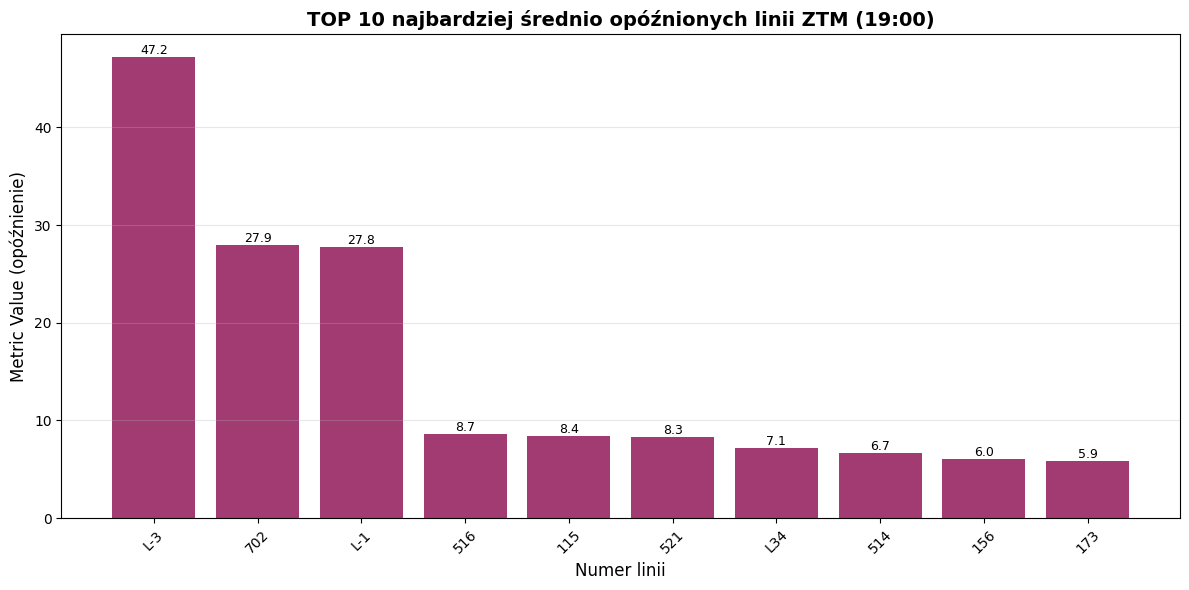

⚠️ Najgorsza linia: L-3 (metric: 47.18)


In [9]:
df_pd = df_ztm_day.toPandas()
top10_delayed = df_pd.nlargest(10, 'metric_val')

plt.figure(figsize=(12, 6))
bars = plt.bar(top10_delayed['line_number'].astype(str), top10_delayed['metric_val'], color='#A23B72')
plt.xlabel('Numer linii', fontsize=12)
plt.ylabel('Metric Value (opóźnienie)', fontsize=12)
plt.title('TOP 10 najbardziej średnio opóźnionych linii ZTM (19:00)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"⚠️ Najgorsza linia: {top10_delayed.iloc[0]['line_number']} (metric: {top10_delayed.iloc[0]['metric_val']:.2f})")

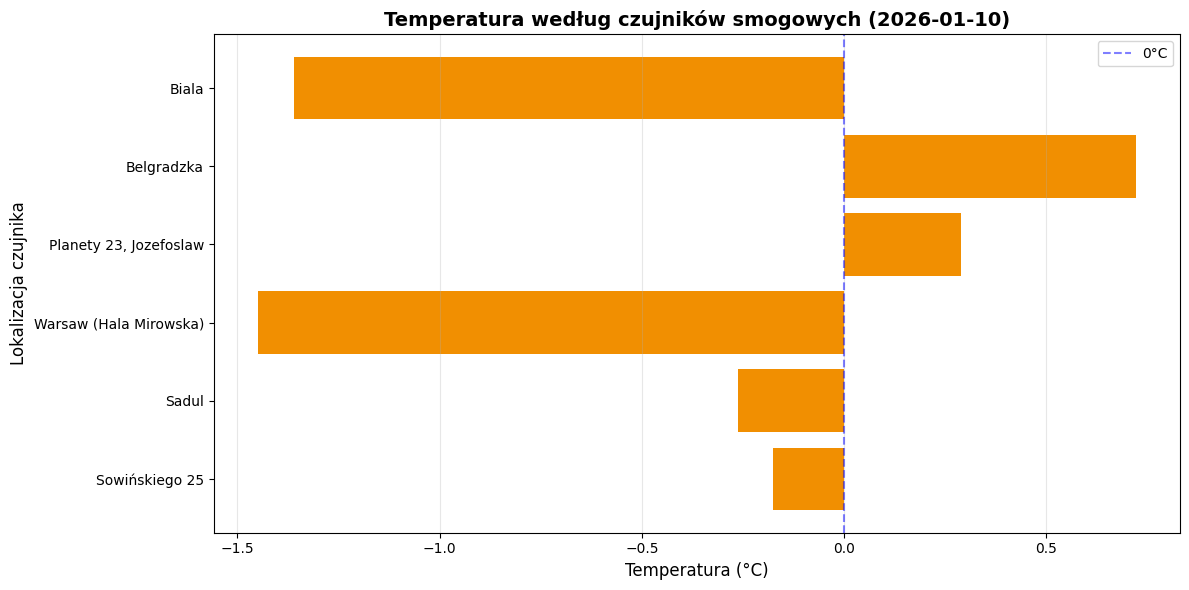

🌡️ Średnia temperatura z czujników: -0.34°C


In [10]:
df_temp = df_air_day.filter(col('parameter') == 'temperature').toPandas()

plt.figure(figsize=(12, 6))
plt.barh(df_temp['location_name'], df_temp['value'], color='#F18F01')
plt.xlabel('Temperatura (°C)', fontsize=12)
plt.ylabel('Lokalizacja czujnika', fontsize=12)
plt.title('Temperatura według czujników smogowych (2026-01-10)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.5, label='0°C')
plt.grid(axis='x', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"🌡️ Średnia temperatura z czujników: {df_temp['value'].mean():.2f}°C")

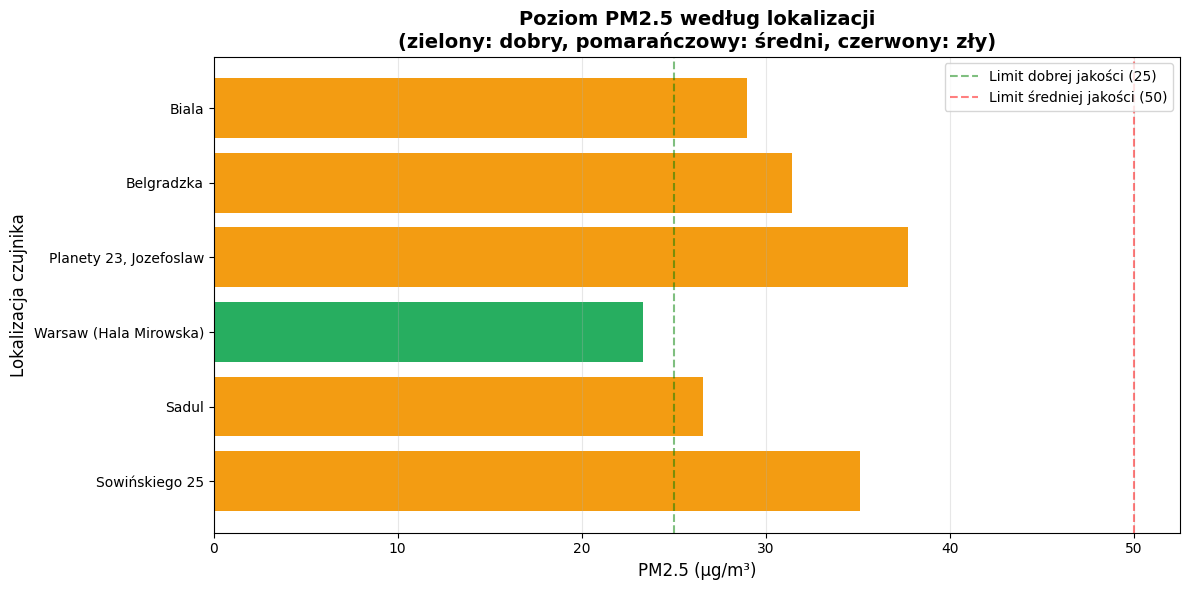

🏭 Średnie PM2.5: 30.52 µg/m³


In [11]:
df_pm25 = df_air_day.filter(col('parameter') == 'pm25').toPandas()

plt.figure(figsize=(12, 6))
colors = ['#27AE60' if x < 25 else '#F39C12' if x < 50 else '#E74C3C' for x in df_pm25['value']]
bars = plt.barh(df_pm25['location_name'], df_pm25['value'], color=colors)

plt.xlabel('PM2.5 (µg/m³)', fontsize=12)
plt.ylabel('Lokalizacja czujnika', fontsize=12)
plt.title('Poziom PM2.5 według lokalizacji\n(zielony: dobry, pomarańczowy: średni, czerwony: zły)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=25, color='green', linestyle='--', alpha=0.5, label='Limit dobrej jakości (25)')
plt.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Limit średniej jakości (50)')
plt.grid(axis='x', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"🏭 Średnie PM2.5: {df_pm25['value'].mean():.2f} µg/m³")

/home/vagrant/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vagrant/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127981 (\N{FACTORY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vagrant/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128653 (\N{ONCOMING BUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vagrant/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


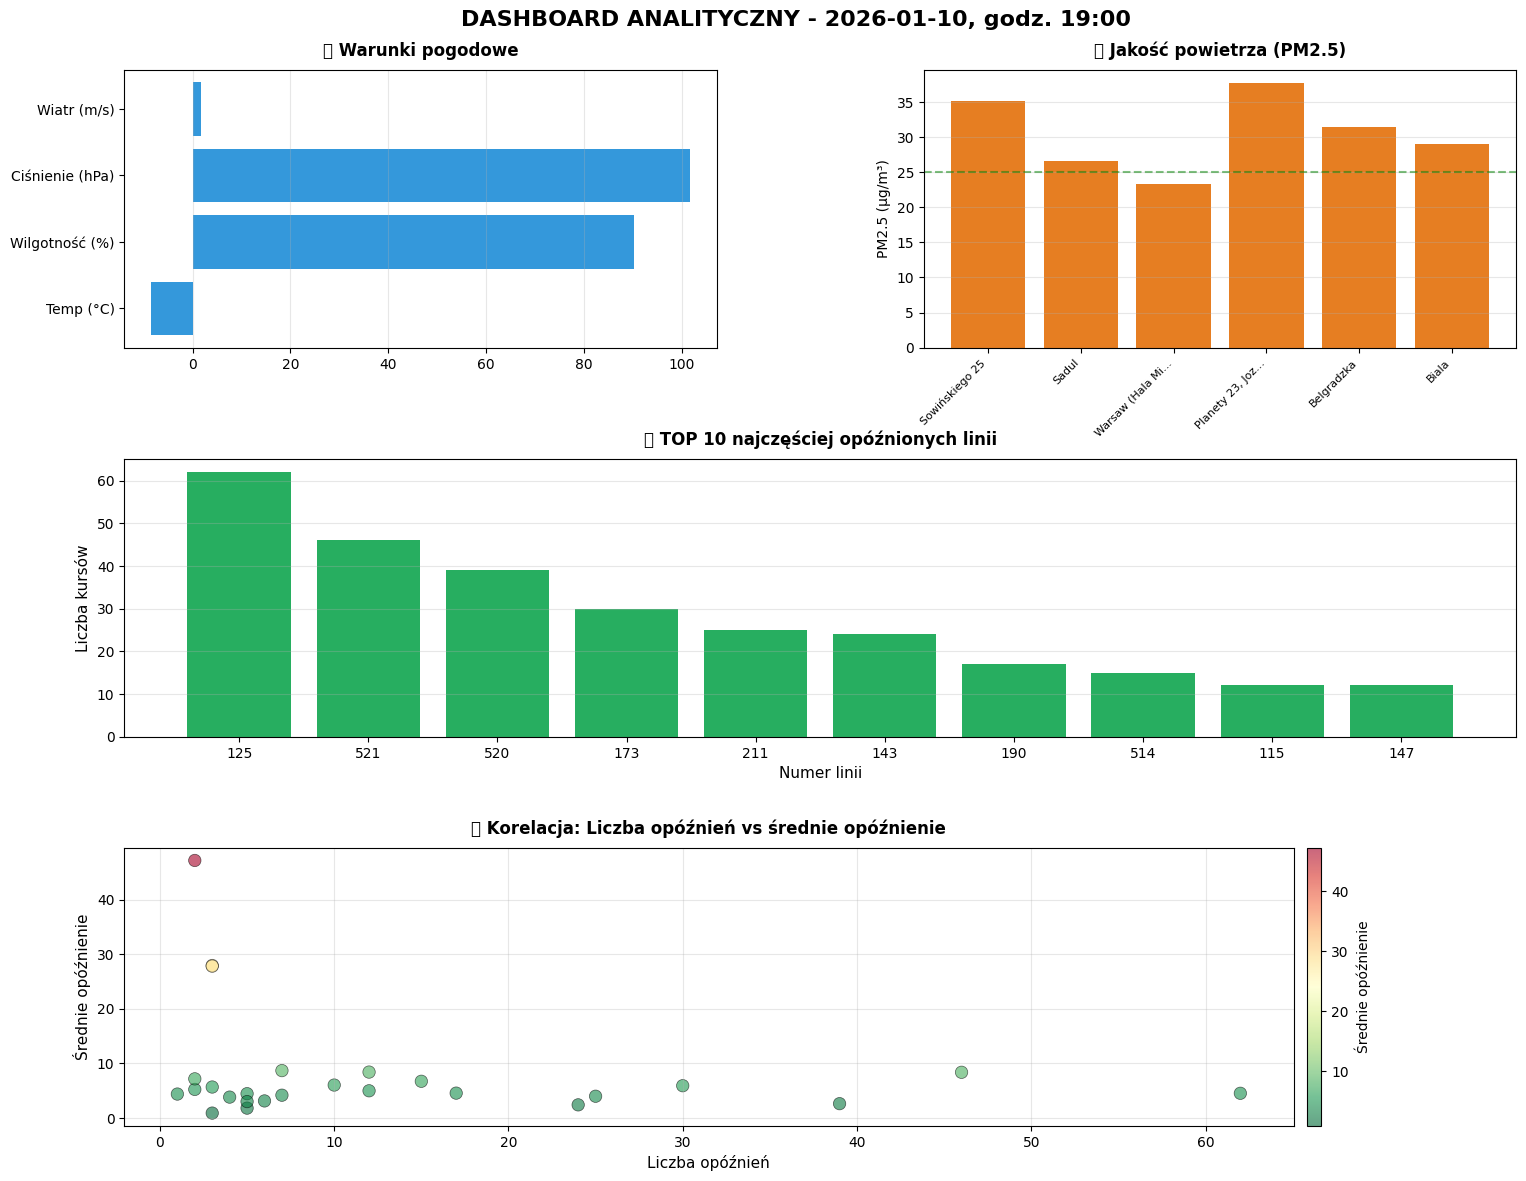

In [14]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.35, top=0.93, bottom=0.05, left=0.08, right=0.95)

# Panel 1: Pogoda (gauges)
ax1 = fig.add_subplot(gs[0, 0])
weather = df_weather_day.collect()[0]
weather_data = {
    'Temp (°C)': weather['avg_temp'],
    'Wilgotność (%)': weather['avg_humidity'],
    'Ciśnienie (hPa)': weather['avg_pressure']/10, 
    'Wiatr (m/s)': weather['avg_wind_speed']
}
ax1.barh(list(weather_data.keys()), list(weather_data.values()), color='#3498DB')
ax1.set_title('🌡️ Warunki pogodowe', fontsize=12, fontweight='bold', pad=10)
ax1.grid(axis='x', alpha=0.3)

# Panel 2: PM2.5
ax2 = fig.add_subplot(gs[0, 1])
df_pm25 = df_air_day.filter(col('parameter') == 'pm25').toPandas()
ax2.bar(range(len(df_pm25)), df_pm25['value'], color='#E67E22')
ax2.set_xticks(range(len(df_pm25)))
ax2.set_xticklabels([loc[:15] + '...' if len(loc) > 15 else loc for loc in df_pm25['location_name']], 
                     rotation=45, ha='right', fontsize=8)
ax2.set_ylabel('PM2.5 (µg/m³)')
ax2.set_title('🏭 Jakość powietrza (PM2.5)', fontsize=12, fontweight='bold', pad=10)
ax2.axhline(y=25, color='green', linestyle='--', alpha=0.5)
ax2.grid(axis='y', alpha=0.3)

# Panel 3: TOP 10 linii (kursy)
ax3 = fig.add_subplot(gs[1, :])
top10 = df_pd.nlargest(10, 'count')
ax3.bar(top10['line_number'].astype(str), top10['count'], color='#27AE60')
ax3.set_xlabel('Numer linii', fontsize=11)
ax3.set_ylabel('Liczba kursów', fontsize=11)
ax3.set_title('🚍 TOP 10 najczęściej opóźnionych linii', fontsize=12, fontweight='bold', pad=10)
ax3.grid(axis='y', alpha=0.3)

# Panel 4: Scatter plot
ax4 = fig.add_subplot(gs[2, :])
scatter = ax4.scatter(df_pd['count'], df_pd['metric_val'], 
                     s=80, alpha=0.6, c=df_pd['metric_val'], 
                     cmap='RdYlGn_r', edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Liczba opóźnień', fontsize=11)
ax4.set_ylabel('Średnie opóźnienie', fontsize=11)
ax4.set_title('📈 Korelacja: Liczba opóźnień vs średnie opóźnienie', fontsize=12, fontweight='bold', pad=10)
ax4.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Średnie opóźnienie', pad=0.01)

plt.suptitle('DASHBOARD ANALITYCZNY - 2026-01-10, godz. 19:00', 
             fontsize=16, fontweight='bold')
plt.show()

In [15]:
from pyspark.sql.functions import corr

print("=== KORELACJA: OPÓŹNIENIE vs LICZBA OPÓŹNIEŃ ===")
correlation = df_ztm_day.select(corr('metric_val', 'count')).collect()[0][0]

print(f"Współczynnik korelacji Pearsona: {correlation:.4f}\n")

if correlation > 0.3:
    print("📊 Pozytywna korelacja: więcej opóźnień → większe opóźnienia")
elif correlation < -0.3:
    print("📊 Negatywna korelacja: więcej opóźnień → mniejsze opóźnienia")
else:
    print("📊 Słaba korelacja: liczba opóźnień nie wpływa znacząco na opóźnienia")

=== KORELACJA: OPÓŹNIENIE vs LICZBA OPÓŹNIEŃ ===
Współczynnik korelacji Pearsona: -0.2238

📊 Słaba korelacja: liczba opóźnień nie wpływa znacząco na opóźnienia


26/01/14 14:19:30 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


In [19]:
from pyspark.sql.functions import col, avg

print("=" * 60)
print("        📋 RAPORT KOŃCOWY - 2026-01-10, godz. 19:00")
print("=" * 60)

weather = df_weather_day.collect()[0]
print(f"\n🌡️  POGODA:")
print(f"   Temperatura: {weather['avg_temp']:.2f}°C")
print(f"   Wilgotność: {weather['avg_humidity']:.2f}%")
print(f"   Ciśnienie: {weather['avg_pressure']:.2f} hPa")
print(f"   Prędkość wiatru: {weather['avg_wind_speed']:.2f} m/s")

avg_pm25_row = df_air_day.filter(col('parameter') == 'pm25').agg(avg('value')).collect()

if avg_pm25_row and avg_pm25_row[0][0] is not None:
    avg_pm25 = avg_pm25_row[0][0]
    print(f"\n🏭 JAKOŚĆ POWIETRZA:")
    print(f"   Średnie PM2.5: {avg_pm25:.2f} µg/m³")
else:
    print(f"\n🏭 JAKOŚĆ POWIETRZA:")
    print(f"   Średnie PM2.5: Brak danych")

total_delays = df_ztm_day.agg({'count': 'sum'}).collect()[0][0]
avg_delay = df_ztm_day.agg({'metric_val': 'avg'}).collect()[0][0]
lines_count = df_ztm_day.count()

print(f"\n🚍 KOMUNIKACJA MIEJSKA (ZTM):")
print(f"   Liczba monitorowanych linii: {lines_count}")
print(f"   Łączna liczba raportowanych zdarzeń: {total_delays}")
if avg_delay:
    print(f"   Średnia wartość metryki: {avg_delay:.2f}")

# Top linie
# Sortujemy malejąco
top_line = df_ztm_day.orderBy(col('count').desc()).first()
worst_line = df_ztm_day.orderBy(col('metric_val').desc()).first()

if top_line:
    print(f"\n⭐ Najwięcej opóźnień autobusów na linii: {top_line['line_number']} (liczba: {top_line['count']})")
if worst_line:
    print(f"⚠️  Najwyższa wartość średniego opóźnienia: {worst_line['line_number']} (metric: {worst_line['metric_val']:.2f})")

print("\n" + "=" * 60)
print(" 🚌📊")
print("=" * 60)

        📋 RAPORT KOŃCOWY - 2026-01-10, godz. 19:00



🌡️  POGODA:
   Temperatura: -8.46°C
   Wilgotność: 90.33%
   Ciśnienie: 1016.33 hPa
   Prędkość wiatru: 1.71 m/s

🏭 JAKOŚĆ POWIETRZA:
   Średnie PM2.5: 30.52 µg/m³


26/01/14 14:23:44 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
26/01/14 14:23:44 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
26/01/14 14:23:44 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
26/01/14 14:23:45 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.



🚍 KOMUNIKACJA MIEJSKA (ZTM):
   Liczba monitorowanych linii: 26
   Łączna liczba raportowanych zdarzeń: 350
   Średnia wartość metryki: 8.20

⭐ Najwięcej opóźnień autobusów na linii: 125 (liczba: 62)
⚠️  Najwyższa wartość średniego opóźnienia: L-3 (metric: 47.18)

 🚌📊


26/01/14 14:23:45 WARN lazy.LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
